In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

# importing comet variables stored in .env file
comet_api_key =  os.getenv("COMET_API_KEY")
comet_project_name = os.getenv("COMET_PROJECT_NAME")
comet_workspace_name = os.getenv("COMET_WORKSPACE_NAME")
# print(api_key)
# print(project_name)
# print(workspace_name)

In [2]:
# Integrating comet to track results
from comet_ml import Experiment
experiment = Experiment(
  api_key=comet_api_key,
  project_name=comet_project_name,
  workspace=comet_workspace_name,
  auto_metric_logging=True,
  auto_param_logging=True,
  auto_histogram_weight_logging=True,
  auto_histogram_gradient_logging=True,
  auto_histogram_activation_logging=True,
  auto_histogram_epoch_rate=True,
  log_code=True
)

# setting the experiment name
experiment.set_name("fine_tune_vgg16_v1_mtcnn")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nikhil527/image-emotion-classifier/99ba2ed13d0445a49dee16c0b2c747fa



COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [3]:
from mtcnn import MTCNN
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, GaussianNoise, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from collections import Counter

from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
import sys 
import os

# Adding the parent directory to the sys.path to access helper_functions
parent_directory = os.path.dirname(os.getcwd())

# Adds our parent directory to the list of paths that python searches for modules
sys.path.append(parent_directory) 

from helper_functions import *

1/1 [==============================] - 0s 282ms/step


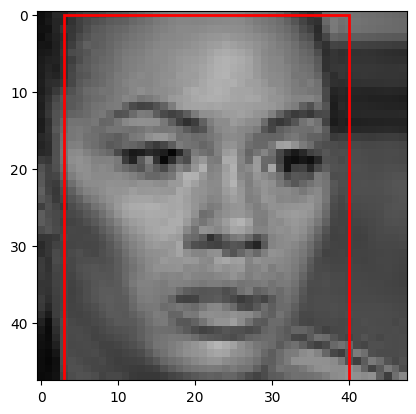

In [5]:
# Lets now try to see how mtcnn is extracting facial features from an image in our dataset

# Loading an image using OpenCV
image = cv2.imread(r'C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\FER2013\train\fear\Training_1369871.jpg')

# Converting our image from BGR which is the color that opencv 
# read images in and converting to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initializing our MTCNN detector
detector = MTCNN()

# Detecting faces in our input image
faces = detector.detect_faces(image)

fig, ax = plt.subplots()
ax.imshow(image)

# Looping through each face detected and plotting a rectangle over the face image
for face in faces:
    x, y, width, height = face['box']
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

##### MTCNN is detecting the facial features from our input image, cropping and extracting them

1/1 [==============================] - 0s 231ms/step


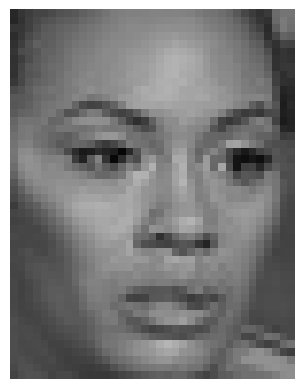

In [6]:
image = cv2.imread(r'C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\FER2013\train\fear\Training_1369871.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detector = MTCNN()

# Detect faces in the image
faces = detector.detect_faces(image)


# Loop through each face detected, crop, and display
# we are Looping through each face detected and 
# cropping and plotting a rectangle over the face image
for i, face in enumerate(faces):
    x, y, width, height = face['box']
    cropped_face = image[y:y+height, x:x+width]

    plt.subplot(1, len(faces), i + 1)
    plt.imshow(cropped_face)
    plt.axis('off')

plt.show()

##### Here above we can see clearly the input image getting cropped to give us the facial features after applying mtccn to feed into our model

In [1]:
## We are trying to proprocess the images using mtcnn and place them
# in a separate directory to then load those image for training
from mtcnn import MTCNN
import cv2
import os


def preprocess_images(input_dir, output_dir):
    detector = MTCNN()
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.png')):
                path = os.path.join(root, file)
                img = cv2.imread(path)
                image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(image)
                for i, face in enumerate(faces):
                    x, y, width, height = face['box']
                    cropped_face = image[y:y+height, x:x+width]

                    rel_path = os.path.relpath(path, input_dir)
                    output_path = os.path.join(output_dir, rel_path)
                    os.makedirs(os.path.dirname(output_path), exist_ok=True)
                    cv2.imwrite(output_path, cropped_face)

input_dir_train = r"C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\FER2013\train"
output_dir_train = r"C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\mtcnn fer2013\train"
preprocess_images(input_dir_train, output_dir_train)

1/1 [==============================] - 0s 33ms/step


In [5]:
input_dir_validation = r"C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\FER2013\test"
output_dir_validation = r"C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\mtcnn fer2013\test"
preprocess_images(input_dir_validation, output_dir_validation)

1/1 [==============================] - 0s 96ms/step


In [7]:
# performing some preprocessing and data augmentation techniques to help our
# model generalize better

# rotation_range, width_shift_range, height_shift_range, zoom_range: 
# These parameters will randomly rotate, shift, and zoom images during training 
# to increase variations in our dataset

# horizontal_flip -> This will randomly flip images. 
# All these techniques will help us in generating new data to help the 
# model generalize better on real-world scenarios


training_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
validation_datagen  = ImageDataGenerator(rescale = 1./255)

testing_datagen  = ImageDataGenerator(rescale = 1./255)

training_dataset_after_mtcnn  = training_datagen.flow_from_directory(directory = r"c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/mtcnn fer2013/train/",
                                                   target_size = (48, 48),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)
validation_dataset_after_mtcnn = validation_datagen.flow_from_directory(directory = r"c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/mtcnn fer2013/test/",
                                                  target_size = (48, 48),
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = 64)

testing_dataset_after_mtcnn = testing_datagen.flow_from_directory(directory = r"C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\CK+\CK+48",
                                                  target_size = (48, 48),
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = 64)

class_labels = training_dataset_after_mtcnn.class_indices


# training_dataset_after_mtcnn = mtcnn_facial_image_generator(training_dataset)
# validation_dataset_after_mtcnn = mtcnn_facial_image_generator(validation_dataset)
# testing_dataset_after_mtcnn = mtcnn_facial_image_generator(testing_dataset)

Found 23380 images belonging to 7 classes.
Found 5850 images belonging to 7 classes.
Found 981 images belonging to 7 classes.


In [8]:
# Setting our base model as vgg16 with pretrained weights from imagenet
base_model = tf.keras.applications.VGG16(input_shape= (48,48, 3),include_top=False,weights="imagenet")
# Freezing the first 11 layers of the base model
for layer in base_model.layers[:11]:
    layer.trainable=False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [9]:
# Defining the architecture of our model

# creates a sequential model to stack our custom layers
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))  # Added as a regularization technique to make the model more robust to slight variations and noise in input data
model.add(GlobalAveragePooling2D()) # performs spatial average pooling on the previous layer's feature maps, reducing the number of parameters and the computational cost and risk of overfitting

model.add(Flatten()) # converts the pooled feature maps into a single vector. It helps transition 2D feature maps to a 1D vector for the fully connected layers that follow
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001))) # First Fully connected layer with 256 neurons, Relu activations, and L2 regularization with a penalty coefficient of 0.001 on both the kernel and bias weights to prevent overfitting
model.add(BatchNormalization()) #To stabilize the training process
model.add(Dropout(0.5)) # randomly drops out 50% of the neurons in the previous layer during training, preventing individual neurons from becoming reliant on each other and improving generalization

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001))) # Second Fully Connected layer has 128 neurons, Relu activation, and uses L2 regularization similar to the first dense layer
# The second Fully connected layer further learns and refines the features for classification
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax")) # gives the probability distribution over 7 classes.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                        

In [10]:
# we are setting the metrics that need to be monitored during our models training
monitor_metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy',metrics=monitor_metrics)

In [11]:
# class_weights ->  This is a dictionary with each class ID mapped to
# a weight. The weights are calculated based on the frequency of each class. 
# our idea here is to give more weight to less frequent classes so that our 
# model does not become biased towards more frequent classes.

counter = Counter(training_dataset_after_mtcnn.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

# This callback helps us in reducing learning rate when a metric has stopped improving
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 6,verbose = 1,factor = 0.50, min_lr = 1e-10)
# saves the best model after each epoch.
mc = ModelCheckpoint('vgg16_v1_mtcnn.h5')
# Stops training the model if validation loss doesnt improve over 6 epochs
es = EarlyStopping(verbose=1, patience=6)

results=model.fit(training_dataset_after_mtcnn,
                  validation_data=validation_dataset_after_mtcnn,
                  epochs = 30,
                  verbose =1,
                  callbacks = [lrd,mc, es], 
                  class_weight = class_weights)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET WARNING: auto_histogram_gradient_logging is True, but inputs and targets are not available; unable to log gradients
COMET WARNING: auto_histogram_activation_logging is True, but inputs are not available; unable to log activations


Epoch 1/30
366/366 [==============================] - 151s 392ms/step - loss: 5.8030 - accuracy: 0.8122 - precision: 0.1792 - recall: 0.0878 - auc: 0.5311 - f1_score: 0.1172 - val_loss: 4.2805 - val_accuracy: 0.7801 - val_precision: 0.1549 - val_recall: 0.1210 - val_auc: 0.5385 - val_f1_score: 0.1352 - lr: 1.0000e-04
Epoch 2/30
366/366 [==============================] - 183s 499ms/step - loss: 4.9502 - accuracy: 0.8273 - precision: 0.2519 - recall: 0.1062 - auc: 0.5871 - f1_score: 0.1490 - val_loss: 25.8368 - val_accuracy: 0.7477 - val_precision: 0.1169 - val_recall: 0.1169 - val_auc: 0.4852 - val_f1_score: 0.1167 - lr: 1.0000e-04
Epoch 3/30
366/366 [==============================] - 216s 588ms/step - loss: 4.9623 - accuracy: 0.8307 - precision: 0.2357 - recall: 0.0827 - auc: 0.5670 - f1_score: 0.1222 - val_loss: 4.5586 - val_accuracy: 0.7888 - val_precision: 0.2607 - val_recall: 0.2603 - val_auc: 0.5811 - val_f1_score: 0.2596 - lr: 1.0000e-04
Epoch 4/30
366/366 [======================

In [12]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nikhil527/image-emotion-classifier/99ba2ed13d0445a49dee16c0b2c747fa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [30]                  : (0.8122265934944153, 0.9125626087188721)
COMET INFO:     auc [30]                       : (0.5311371088027954, 0.9282999038696289)
COMET INFO:     batch_accuracy [1110]          : (0.7901785969734192, 0.9330357313156128)
COMET INFO:     batch_auc [1110]               : (0.4756062626838684, 0.9537150859832764)
COMET INFO:     batch_f1_score [1110]          : (0.09615379571914673, 0.7321428060531616)
COMET INFO:     batch_loss [1110]              : (1.4235132932662964, 7.282

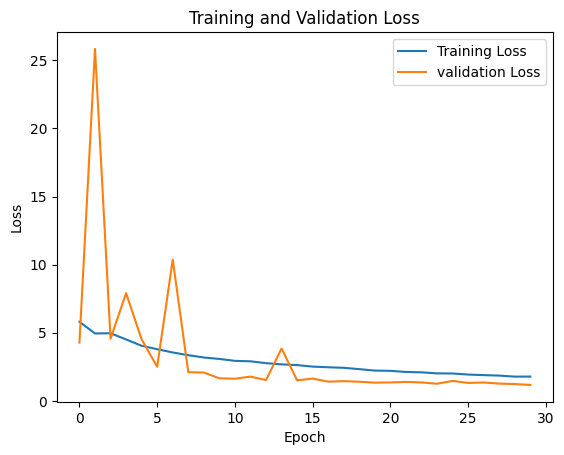

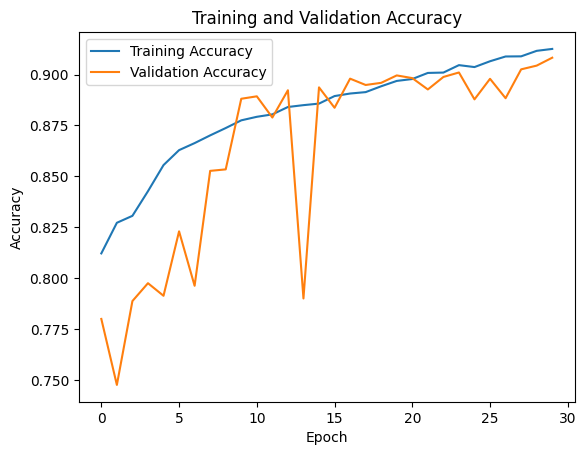

In [13]:
# Plotting the graph for training, validation accuracies and losses
plot_graph(results)

In [14]:
first_batch_images, first_batch_labels = next(testing_dataset_after_mtcnn)

Text(0.5, 1.0, 'neutral')

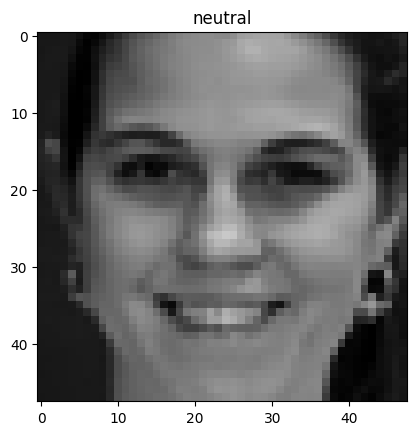

In [15]:
# predicts the label for an image
def compute_label(label_array, class_indexes):
    predicted_class_index = np.argmax(label_array)
    predicted_class = list(class_indexes.keys())[predicted_class_index]
    return predicted_class

plt.imshow(first_batch_images[5])
plt.title(compute_label(first_batch_labels[5], class_labels))

1/1 [==============================] - 0s 43ms/step


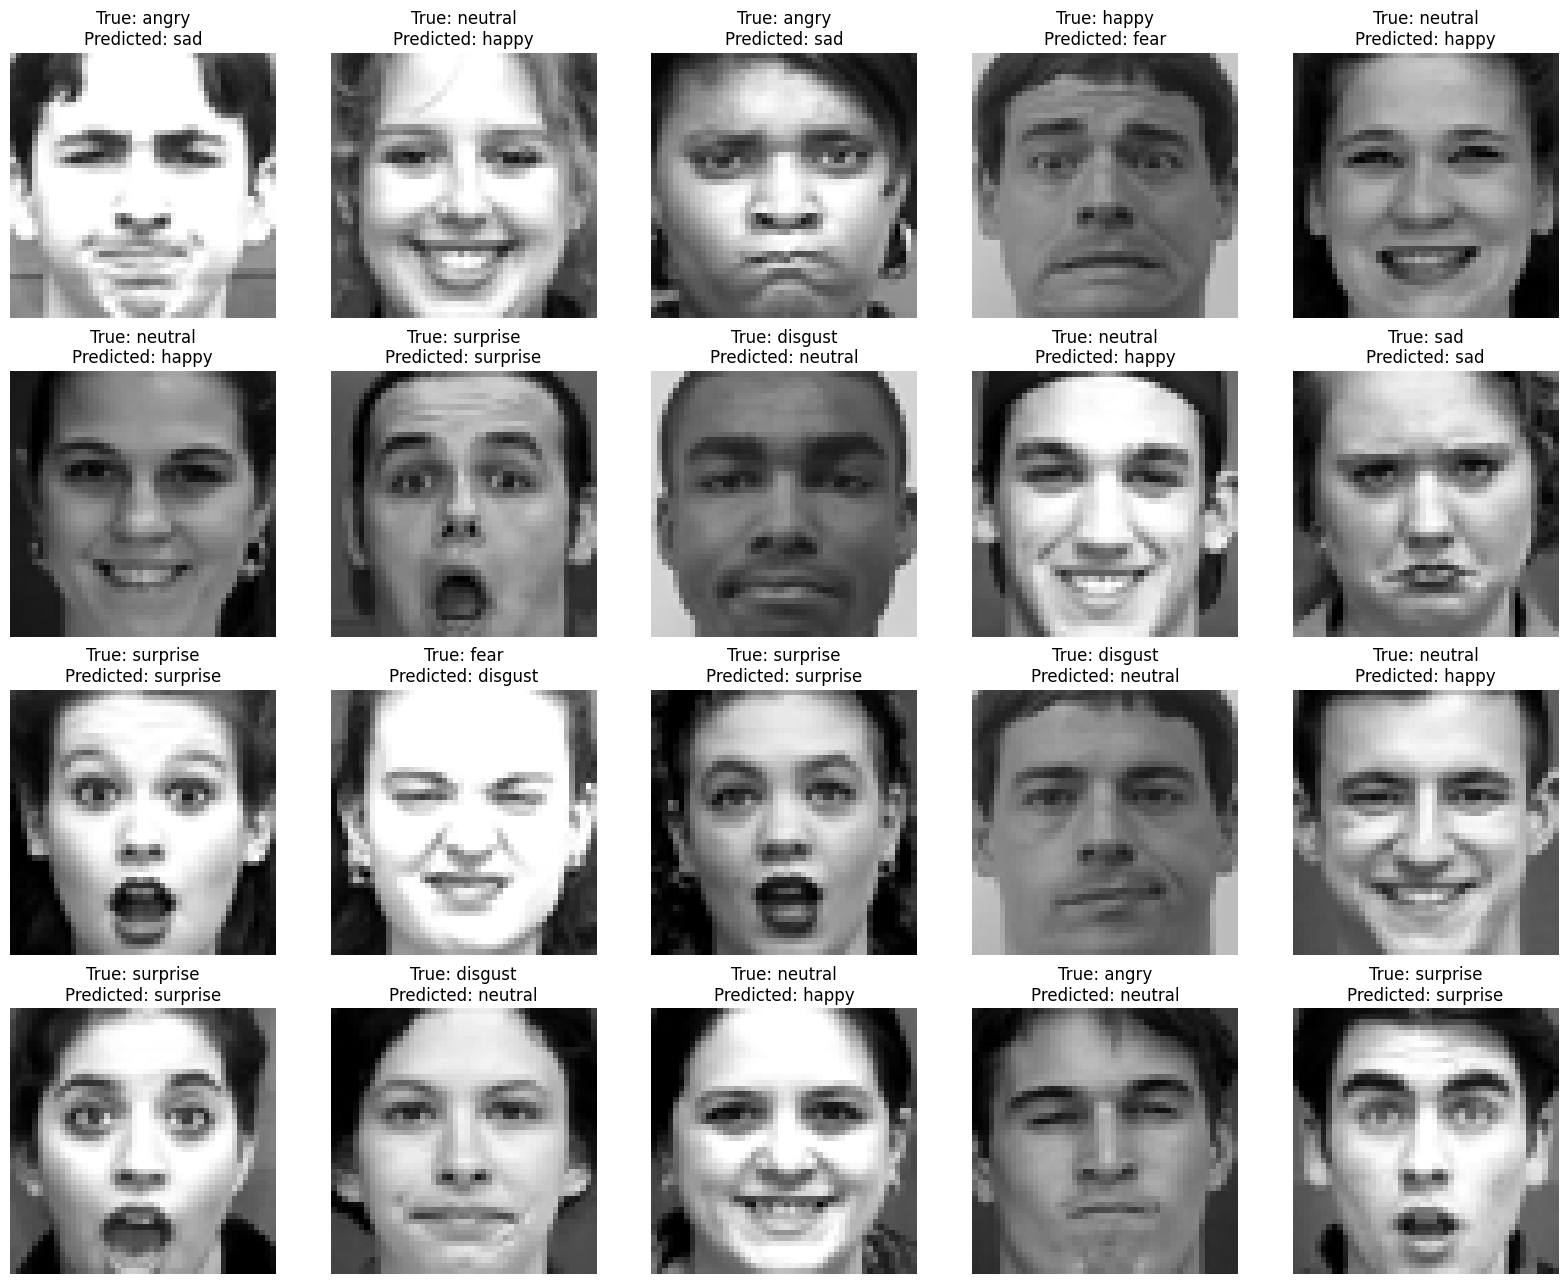

In [16]:
# Predicting using our model on CK+ dataset
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

1/1 [==============================] - 0s 43ms/step


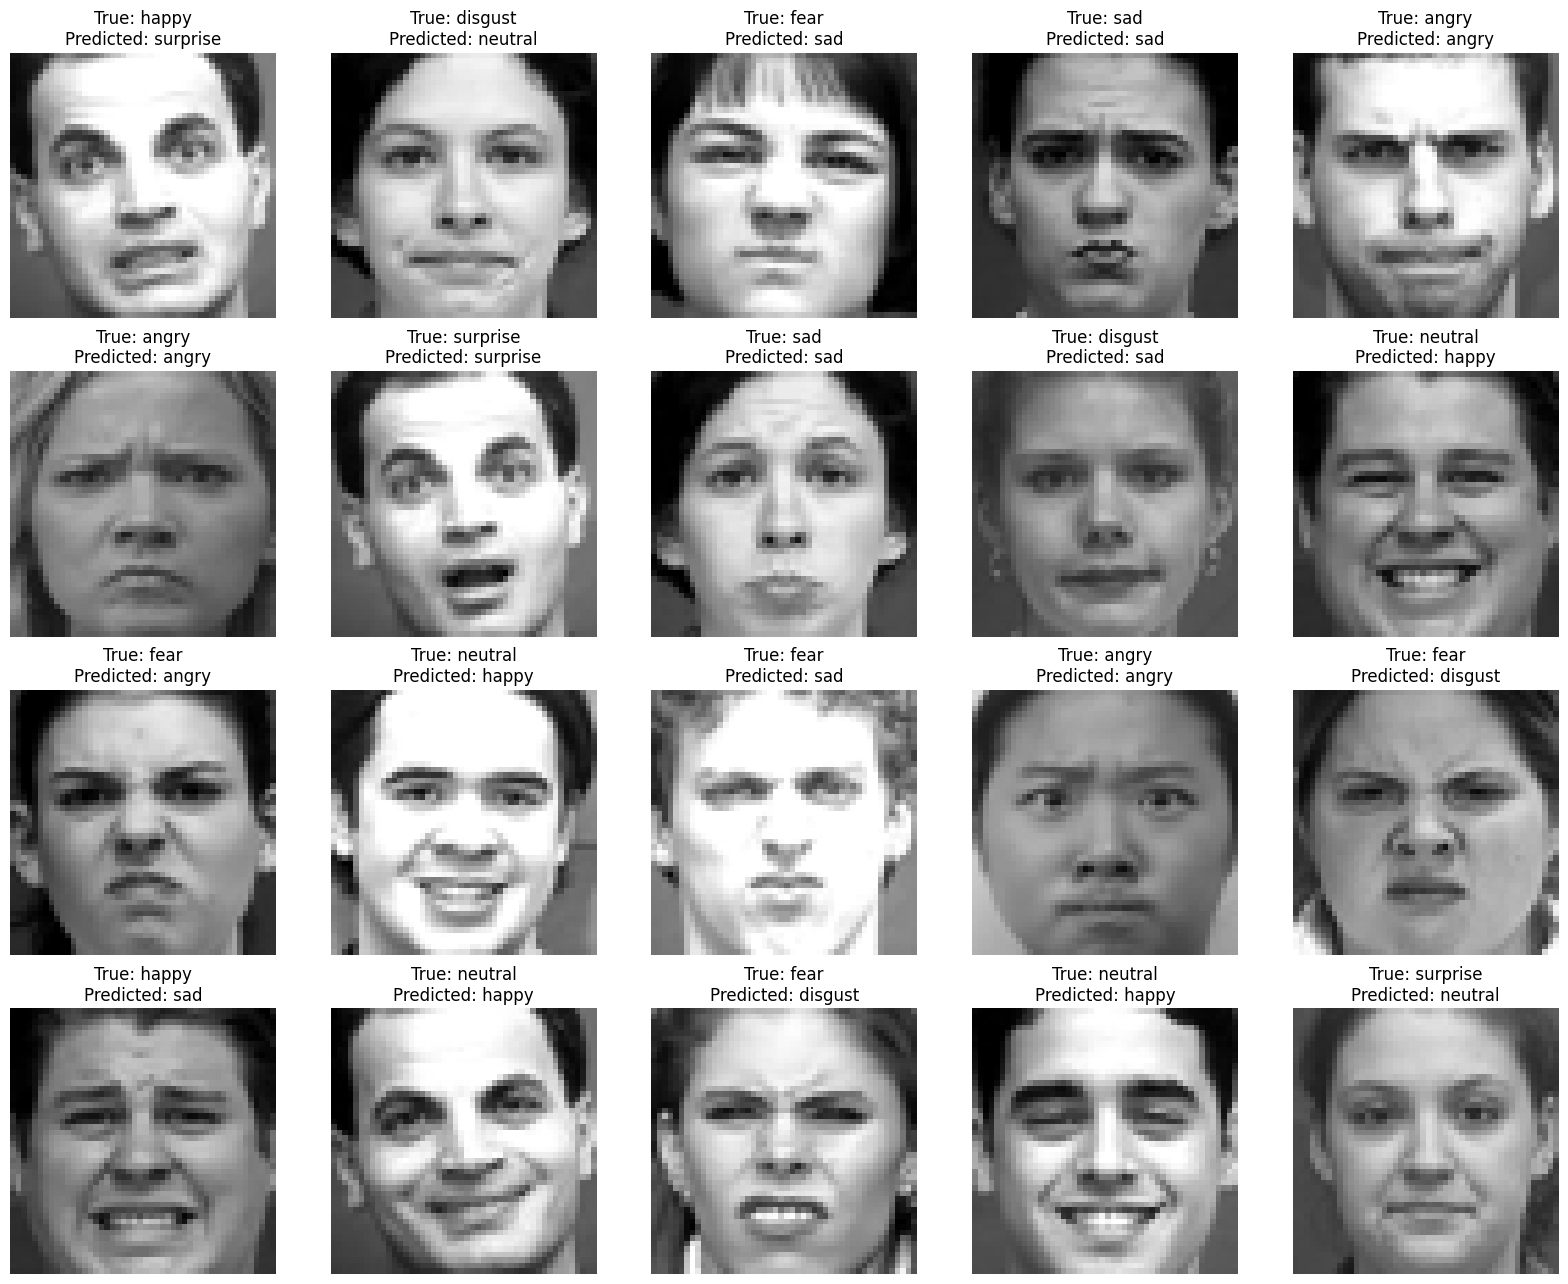

In [17]:
plt.figure(figsize=(20, 20))
j=1
for i in range(21, 41):
    plt.subplot(5,5,j)
    j = j+1
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

##### 1] In the above plot if u see the 2nd photo in last row. the true label is neutral but the image is of "happy" emotion and our model is predicting this correctly.
##### 2] If we see the third image in the last row the true label is "fear" but we can infer that it is "disgust" emotion and our model is predicting that accurately.
##### 3] similarly if we see the 4th image in the last row our model is predicting correctly as "happy" even though there is a misclassification in test dataset.

##### 4] Similarly we observe the same situation with 1st image in 3th row

##### Our model is generalizing better on unseen data.

1/1 [==============================] - 0s 33ms/step


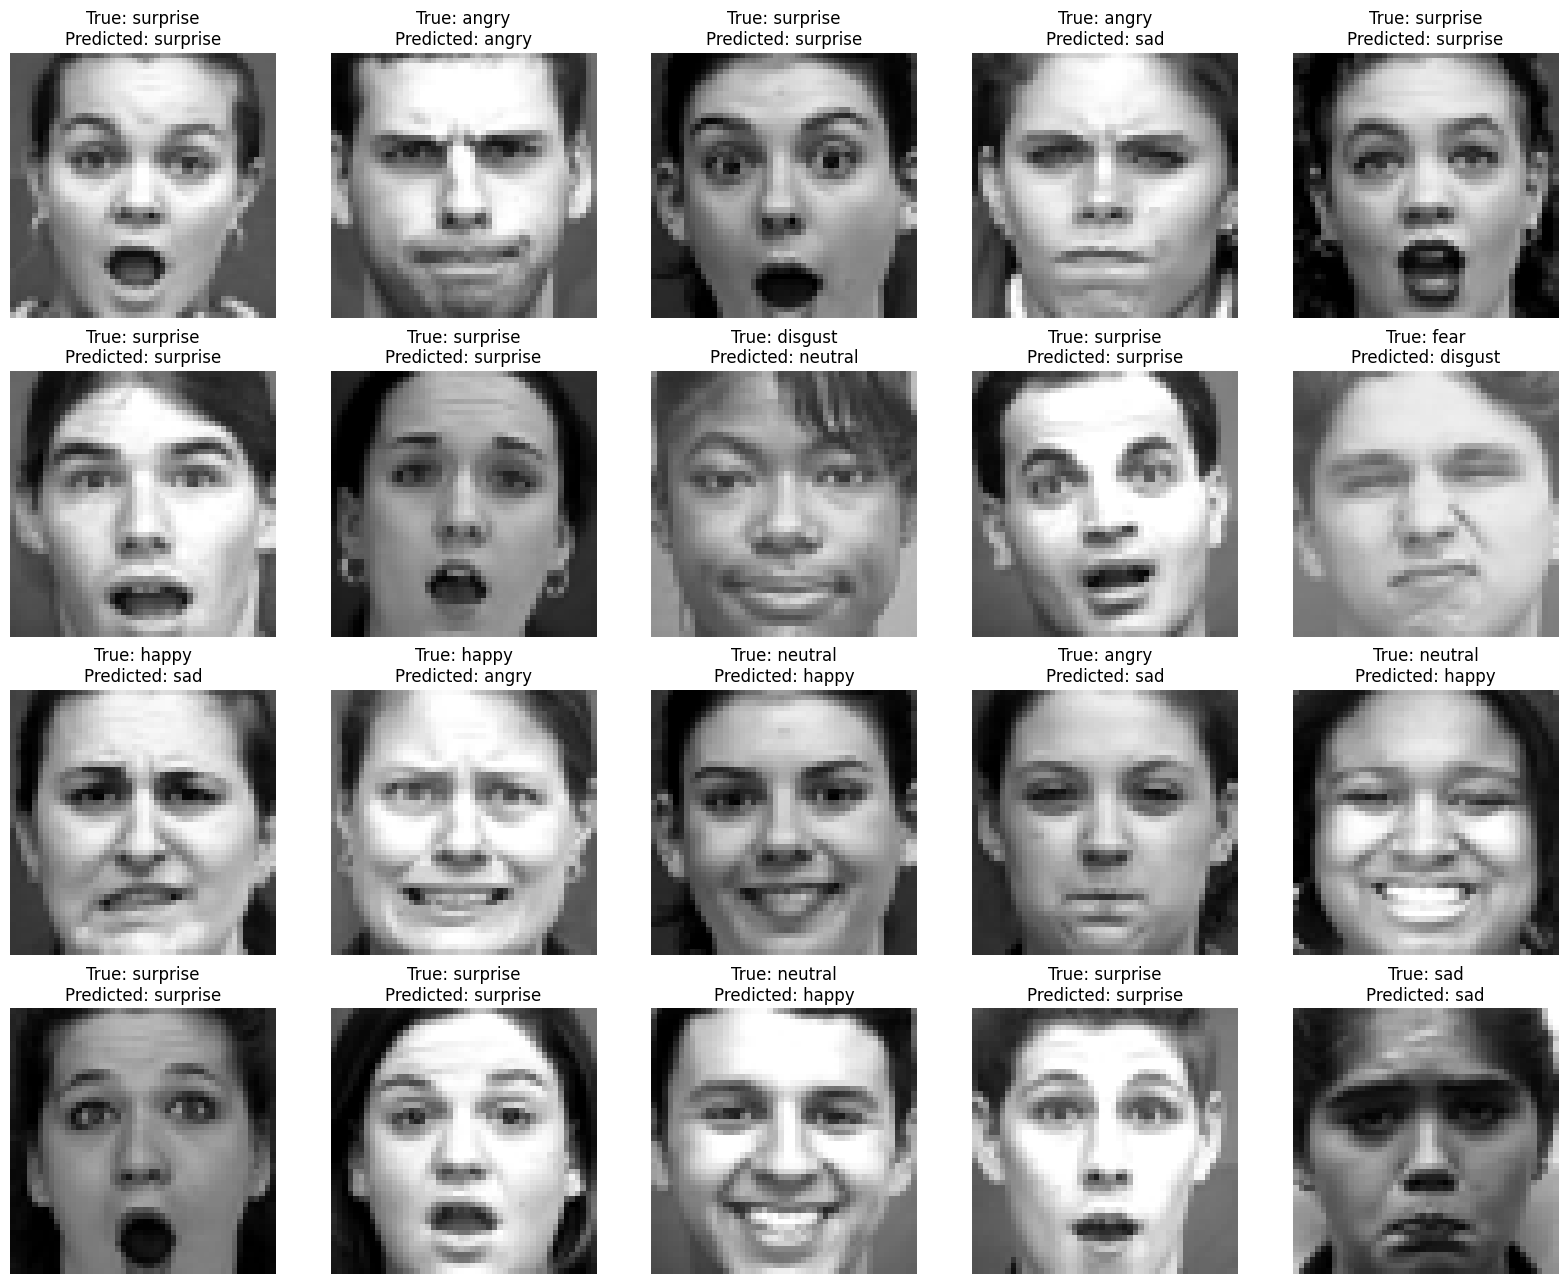

In [18]:
plt.figure(figsize=(20, 20))
j=1
for i in range(41, 61):
    plt.subplot(5,5,j)
    j = j+1
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

##### 1] Here if we observe in the above image model is predicting really well. if we observe the 3rd photo in the last row the actual label is "neutral" which seems to be a missclassification in the test dataset but our model does a really good job at Identifying the emotion as "happy". 

##### 2] If we observe the last photo in second row the true lable is "fear" which might be a misclassification but our model does a good job at predicting that the image is of emotion "disgust"

##### Our model is generalizing well on unseen data.